In [1]:
# %magic

In [11]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
# import holoviews as hv
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import FuncTickFormatter, HoverTool
from bokeh.models import FixedTicker
import probscale

<p style="font-family:Arial; font-size:2em; color:purple; font-style:bold"><br>
Two-parameter Weibull Distribution:</p>

<font size ='5'>$$f(t)={ \frac{\beta }{\eta }}\left( {\frac{t}{\eta }}\right) ^{\beta -1}e^{-\left( { \frac{t}{\eta }}\right) ^{\beta }}$$<font>
    
<font size=4>$$\beta=shape, \ \eta=scale$$</font>

### Weibull plot is the plot of <font size=4> $\ln[-\ln[ 1-F(data)]]\ vs.\ \ln(data)$ </font>  
### Straight line equation: <font size=4> $\ln[-\ln[ 1-F(data)]] =-\beta\ln(\eta)+\beta\ln(data) \ ----> \ y=c+mx$ </font>  
<font size=4> where: $y=\ln[-\ln[ 1-F(data)]] \\x=\ln(data) \\m=slope=\beta \\c=intercept=-\beta\ln(\eta)$ </font>

In [2]:
# Formatting y-axis data to CDF values
def yformatter(y, pos):
    return '%g%%' % (100*(1-np.exp(-np.exp(y))))

In [3]:
# class for calculating different type of ranks
class medianrank():
    def __init__(self, size, num_of_failed_items):
        self.size = size
        self.num_of_failed_items = num_of_failed_items
    def get_benard_median_rank(self):
        return (np.arange(1, self.num_of_failed_items+1) - 0.3)/(self.size + 0.4)
    def get_hazen_median_rank(self):
        return (np.arange(1, self.num_of_failed_items+1) - 0.5)/self.size
    def get_meanrank(self):
        return np.arange(1, self.num_of_failed_items+1)/(self.size+1)
    def get_white_median_rank(self):
        return (np.arange(1, self.num_of_failed_items+1) - 3/8)/(self.size+1/4)

In [5]:
# Failure data

# data = np.array([100, 150, 220, 250, 280, 310, 330, 360, 380, 395, 410, 430])
data = stats.weibull_min.rvs(c=3.5, loc=0, scale=300, size=50)
data = np.array([130, 165, 234, 252, 253, 295, 389])
data = np.array([1000, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000])
# data = stats.norm.rvs(size=100, loc=20, scale=200)
# data = stats.norm.rvs(loc=300, scale=100, size=50)
total_products = data.size

if False:
    # total products under test
    total_products = 20
    # out of 20 product 14 failed.
    data = np.array([70, 128, 204, 291, 312, 377, 473, 549, 591, 663, 748, 827, 903, 955])

data = data.astype(int)
data = abs(data)
data.sort()
print(data)

[1000 1200 1300 1400 1500 1600 1700 1800 1900 2000 2200 2400 2600 2800
 3000 3200 3400 3600 3800 4000]


shape: 2.76, scale: 2610.06


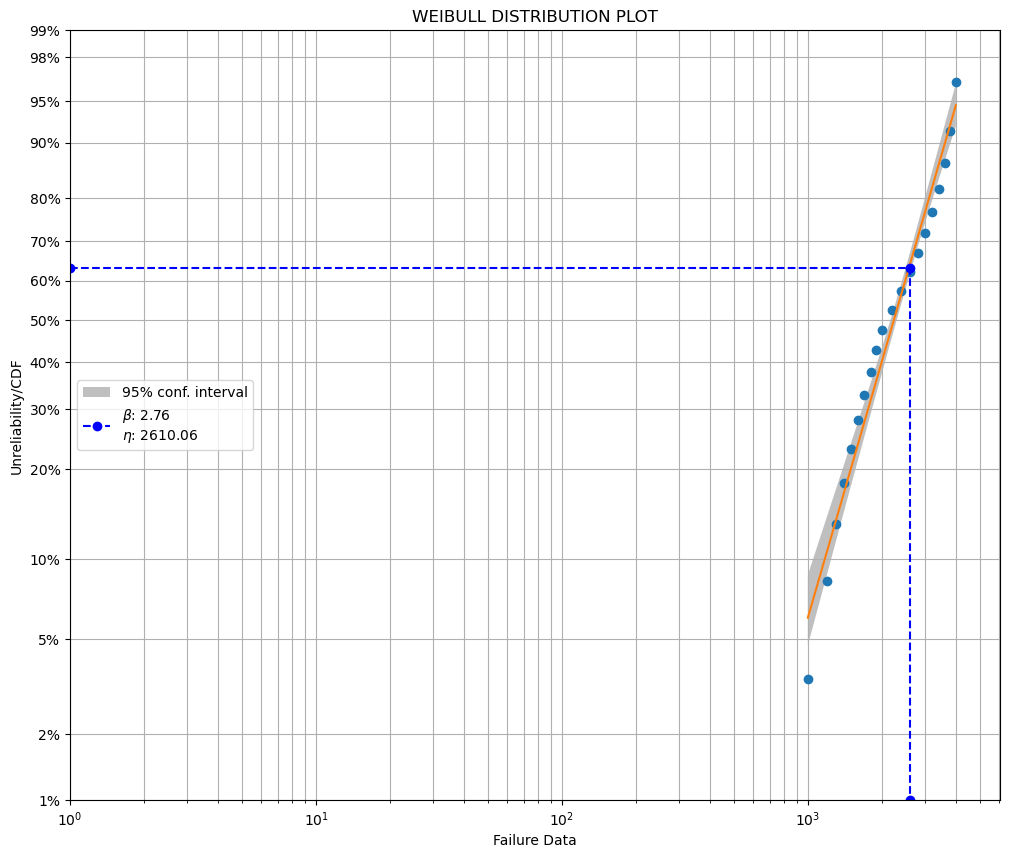

In [12]:
# Some quick idea on fit & distribution, set 'c' value to fit the line, make it large if it doesn't fit & see..
# probscale uses Linear Regression method
if True:
    weibull_min = stats.weibull_min(c=10)
    fig, ax = plt.subplots(figsize=(12, 10),)
    pfig, fit_results = probscale.probplot(data, dist=weibull_min, datascale='log', bestfit=True, 
                                           probax='y', plottype='prob', return_best_fit_results=True, estimate_ci=True,
                                           pp_kws={'alpha': 0.3, 'beta': 0.3},
                                           )
    fity = np.log(-np.log(1- fit_results['y']/100))
    slope_probscale, intercept_probscale, *temp =  stats.linregress(np.log(fit_results['x']), fity)
    eta = np.exp(-intercept_probscale/slope_probscale)
    plt.plot([1, eta, eta], [63.2, 63.2, 1], ls='--', color='blue', marker='o', 
             label = r'$\beta$: ' + f'{slope_probscale:0.2f}' + '\n' + r'$\eta$: ' + f'{eta:0.2f}')
    print(f'shape: {slope_probscale:0.2f}, scale: {eta:0.2f}')
    ax.grid('True', 'both')
    plt.xlim(1, )
    plt.ylim(1, )
    plt.xlabel('Failure Data')
    plt.ylabel('Unreliability/CDF')
    plt.legend(loc = 'center left')
    plt.title('WEIBULL DISTRIBUTION PLOT')
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.show()

### Finding Weibull Distribution Parameters: 
- $\beta$, shape/slope
- $\eta$, scale/eta, Characteristic Life


Two methods are used to calculate distribution parameters:
- Linear Regression Method
- MLE Method


This is important, remember:
- Thumb rule: Large samples use MLE, small samples use Linear Regression.
- Go for linear regression for data points less than 15 or if MLE doesn't fit Weibull line plot properly to the data
- Use linear regression use for cases like 14 failed out of 20 under test


How to check data fits Weibull Distribution:
- Best way is check the data for both linear & MLE, if both didn't fit the line then the distribution is not Weibull

In [8]:
# median_rank is nothing but F(t)
rank = medianrank(size=total_products, num_of_failed_items=data.size)
median_rank = rank.get_benard_median_rank()

# Weibull plot is the plot of "np.log(-np.log(1-F(data))) vs np.log(data)"
y_from_data = np.log(-np.log(1-median_rank))

if (data.size == total_products):
    if data.size > 15:
        # Calculate parameters using MLE
        print('MLE Method')
        shape, loc, scale = stats.weibull_min.fit(data, floc = 0, optimizer = 'powell')
        print(f'shape: {shape:0.2f}, scale: {scale:0.2f}')
    else:
        # Calculate parameters using Linear Regression (Rank Regression)
        print('LR Method, data size less than 15')
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(np.log(data), y_from_data)
        shape = slope
        scale = np.exp(-intercept/slope)
        print(f'shape: {shape:0.2f}, scale: {scale:0.2f}, intercept: {intercept:0.2f}')
else:
    # Calculate parameters using Linear Regression (Rank Regression)
    # use this for cases like 14 failed out of 20 under test
    print('LR Method, not all products failed')
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(np.log(data), y_from_data)
    shape = slope
    scale = np.exp(-intercept/slope)
    print(f'shape: {shape:0.2f}, scale: {scale:0.2f}, intercept: {intercept:0.2f}')

MLE Method
shape: 2.81, scale: 2615.42


### Calculating Points, X:=Time & Y:=CDF(Unreliability) for Weibull Line
- The distribution parameters calculated above are used to find the points with following one of the methods:
    - Y on X Regression, X is independent & Y dependent variable - for given failure time calculate CDF
    - X on Y Regression, X is dependent & Y independent varibale - for given CDF calculate failure time

Note: Plotting is always Y vs X irrespective of regression method.

In [9]:
# Calculate points for Weibull Line Plot
# Weibull Y on X Regression Equation: 
    # np.log(-np.log(1-F(data))) = shape * np.log(data) - shape * np.log(scale)
    # Let x = np.log(data) & y = np.log(-np.log(1-F(data)))
    # y = shape * x - shape * np.log(scale)  => straight line equation y=mx+c, 
    # where m=scale & c=-shape*np.log(scale)
# X on Y Regression Equation from above Y on X Equation:
    # x = y/shape + np.log(scale)) => straight line equation x=my+c,
    # where m=1/shape & c=np.log(scale)
    # replace x with np.log(x_fit_line), take np.exp() on both sides for 'x_fit_line'
    # x_fit_line = np.exp(y)/shape + np.log(scale) 
y = np.arange(0.001, 1, 0.01)
y_fit_line = np.log(-np.log(1-y))
x_fit_line = np.exp(y_fit_line/shape + np.log(scale))

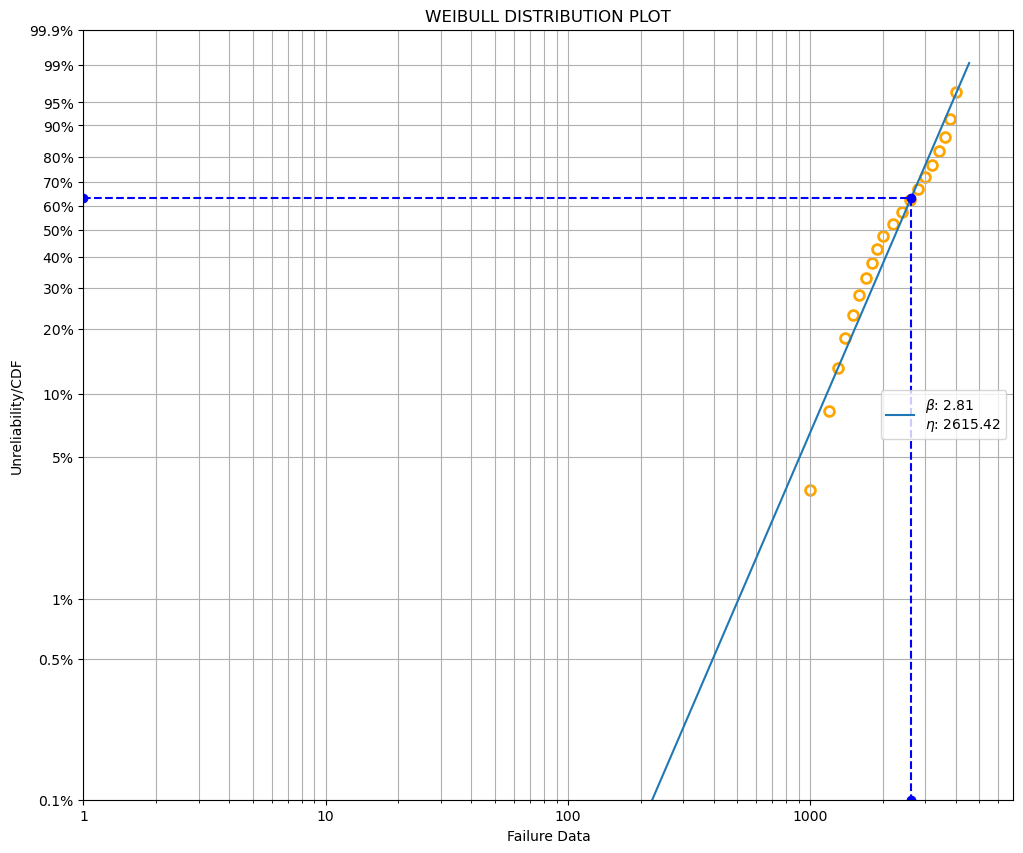

In [10]:
# We are plotting 'data' & not np.log(data), refer to plt.plot function calls below.
# Since Weibull plot is plot of "np.log(-np.log(1-F(data))) vs np.log(data)", 
# xscale set to 'log' will display 'data' in log format, which is what we want.
# Y-axis points for scale, characteristic life
y_point_scale = np.log(-np.log(1-0.632))
y_point_end = np.log(-np.log(1-0.001))

plt.subplots(figsize=(12, 10), subplot_kw={'xscale': 'log'})
plt.plot(x_fit_line, y_fit_line, label = r'$\beta$: ' + f'{shape:0.2f}' + '\n' + r'$\eta$: ' + f'{scale:0.2f}')
plt.scatter(data, y_from_data, marker='o', c='white', s=50, edgecolors='orange', linewidths=2)
plt.plot([1, scale, scale], [y_point_scale, y_point_scale, y_point_end], ls='--', color='blue', marker='o')
plt.ylim(np.log(-np.log(1-0.001)), 1)
plt.xlim(1, )
plt.xlabel('Failure Data')
plt.ylabel('Unreliability/CDF')
# plt.tick_params(axis='y', which='minor')

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.LogFormatter())
#  Important: now change/overlap y-axis tick data to corresponding CDF. Everything here is changing the y-axis format
ax.yaxis.set_major_formatter(plt.FuncFormatter(yformatter))
ticksy = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])
ticksy_1 = np.log(-np.log(1-ticksy))
plt.grid('True', which='both')
plt.yticks(ticksy_1)
plt.legend(loc = 'center right')

plt.title('WEIBULL DISTRIBUTION PLOT')
plt.show()

In [10]:
# Create dataframe for bokeh. cdf_line & cdf_data are used in Y-axis hover.
df_fit_line = pd.DataFrame({'x_fit_line': x_fit_line, 'y_fit_line': y_fit_line, 'cdf_line': [f'{(100*(1-np.exp(-np.exp(i)))):.{3}}%' for i in y_fit_line]})
df_data = pd.DataFrame({'data': data, 'y_from_data': y_from_data, 'cdf_data':[f'{(100*(1-np.exp(-np.exp(i)))):.{3}}%' for i in y_from_data]})
# beta & eta symbols
label1 = '\u03B2'
label2 = '\u03B7'
label1, label2

('β', 'η')

In [11]:
# [f'{(100*(1-np.exp(-np.exp(i)))):.{3}}%' for i in y_fit_line]

In [12]:
label1 + ':' + '{:0.3f}'.format(shape) + ',\n' + label2 + ':' + '{:0.2f}'.format(scale)
f'{label1}={shape:.{4}}, {label2}={scale:.{4}}'

'β=2.911, η=276.8'

In [13]:
# Bokeh Plots

# output to notebook
output_notebook()

# Figure

p=figure(x_axis_type='log', width=730, height=730)
p.background_fill_color = 'lemonchiffon'
p.border_fill_color = 'lemonchiffon'
p.toolbar.active_drag = None
p.toolbar_location = None
p.margin = 5

# Y-axis points for scale, characteristic life
y_point_scale = np.log(-np.log(1-0.632))
y_point_end = np.log(-np.log(1-0.001))

# Plots
lr1 = p.line(source=df_fit_line, x='x_fit_line', y='y_fit_line', line_width=2, line_dash='solid')
sr = p.circle(source=df_data, x='data', y='y_from_data', fill_color='white', size=5.5, line_color='orange', line_width=2)
lr2 = p.line(x = np.array([1, scale, scale]), y=np.array([y_point_scale, y_point_scale, y_point_end]), line_width= 1, line_color = 'gray', 
       line_dash='dashed', legend_label=f'{label1}={shape:.{4}}, {label2}={scale:.{4}}')

# Axes labels
p.xaxis.axis_label = 'Failure Data'
p.xaxis.axis_label_text_font_style = 'bold'
p.xaxis.major_label_text_font_style = 'bold'
p.xaxis.major_label_orientation = 45

p.yaxis.axis_label = 'Unreliability/CDF'
p.yaxis.axis_label_text_font_style = 'bold'
p.yaxis.major_label_text_font_style = 'bold'

# Formattting Y-axis data
p.yaxis.formatter = FuncTickFormatter(code=""" return (100*(1-Math.exp(-Math.exp(tick)))).toFixed(1) + "%" """)

# Updating Y-axis ticks
p.y_range.start = np.log(-np.log(1-0.001))
new_ticks_cdf = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])
new_ticks_y = np.log(-np.log(1-new_ticks_cdf))
p.yaxis.ticker = FixedTicker(ticks=new_ticks_y)

# Formatting X-axis ticks
# p.x_range.start = 10 if df_data[df_data['data']<100]['data'].any() else 100
p.x_range.start = 10

# Grid
p.xgrid.grid_line_alpha = 0.3
p.xgrid.grid_line_color = 'gray'
p.ygrid.grid_line_alpha = 0.3
p.ygrid.grid_line_color = 'gray'
p.xgrid.minor_grid_line_alpha = 0.2
p.xgrid.minor_grid_line_color = 'gray'

# Title
p.title.text = 'WEIBULL PLOT'
p.title_location = 'above'
p.legend.location ='center_right'
p.legend.background_fill_color = 'white'
p.legend.background_fill_alpha = 0.9
p.legend.label_text_color = 'black'

#Add hover
p.add_tools(HoverTool(tooltips=[('X_Fit_Line', '@x_fit_line'), ('CDF_Line', '@cdf_line')], renderers=[lr1]))
p.add_tools(HoverTool(tooltips=[('Data', '@data'), ('CDF_Data', '@cdf_data')], renderers=[sr]))
p.add_tools(HoverTool(tooltips=None, renderers=[lr2])) # hover not required

show(p)


Loading BokehJS ...